In [31]:
import config
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import torch
from seed import seed_everything

pl.Config.set_tbl_rows(500)
pl.Config.set_tbl_cols(500)

print("PyTorch version: ", torch.__version__)
print("CUDA available: ", torch.cuda.is_available())


PyTorch version:  2.4.1+cu121
CUDA available:  False


In [4]:
# ====================================================
# Configurations
# ====================================================
class CFG:
    DRY_RUN = False
    EXP_NAME = config.EXP_NAME
    AUTHOR = "marumarukun"
    COMPETITION = config.KAGGLE_COMPETITION_NAME
    DATA_PATH = config.COMP_DATASET_DIR
    OUTPUT_DIR = config.OUTPUT_DIR
    MODEL_PATH = config.OUTPUT_DIR / "models"  # モデル作成・実験時はこちらを使用
    # MODEL_PATH = config.ARTIFACT_EXP_DIR(config.EXP_NAME) / "models"  # 提出時はこちらを使用
    SEED = 42
    n_folds = 2 if DRY_RUN else 10
    epochs = 1 if DRY_RUN else 10
    target_col_list = ["y"]
    # group_col = "race_group"  # Required for GroupKFold (edit as needed)
    stratified_col = "race_group_efs"  # Required for StratifiedKFold (edit as needed)


# ====================================================
# Seed everything
# ====================================================
seed_everything(CFG.SEED)


In [7]:
# ====================================================
# Read data
# ====================================================
test = pl.read_csv(CFG.DATA_PATH / "test.csv", try_parse_dates=True)
train = pl.read_csv(CFG.DATA_PATH / "train.csv", try_parse_dates=True)

print("test.shape: ", test.shape)
print("train.shape: ", train.shape)
display(test.head(3))
display(train.head(3))


test.shape:  (3, 58)
train.shape:  (28800, 60)


ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
i64,str,str,str,str,f64,f64,str,str,f64,str,str,str,str,str,f64,str,f64,f64,str,f64,f64,str,f64,f64,str,str,str,str,i64,str,str,str,str,f64,str,f64,str,f64,str,f64,f64,str,str,str,f64,str,f64,f64,str,str,str,str,f64,str,f64,str,f64
28800,"""N/A - non-malignant indication""","""No""",null,"""No""",null,null,"""No TBI""","""No""",6.0,"""Bone marrow""","""No""","""No""","""No""","""IEA""",6.0,"""+/+""",null,2.0,null,6.0,2.0,"""No""",2.0,2.0,"""BM""",null,null,"""Not Hispanic or Latino""",2016,"""No""",null,"""Yes""",null,2.0,"""No""",null,"""No""",2.0,"""No""",9.942,2.0,"""FKalone""","""No""","""M-F""",2.0,"""More than one race""",0.0,90.0,"""No""",null,"""Unrelated""","""N/A, Mel not given""",8.0,"""No""",2.0,"""No""",10.0
28801,"""Intermediate""","""No""","""Intermediate""","""No""",2.0,8.0,"""TBI +- Other, >cGy""","""No""",6.0,"""Peripheral blood""","""No""","""No""","""No""","""AML""",6.0,"""+/+""",10.0,2.0,"""P/P""",6.0,2.0,"""No""",2.0,2.0,"""PB""","""Intermediate""","""MAC""","""Not Hispanic or Latino""",2008,"""No""","""Positive""","""No""","""Permissive""",2.0,"""No""",72.29,"""No""",2.0,"""No""",43.705,2.0,"""Other GVHD Prophylaxis""","""No""","""F-F""",2.0,"""Asian""",3.0,90.0,"""No""","""Permissive mismatched""","""Related""","""N/A, Mel not given""",8.0,"""No""",2.0,"""Yes""",10.0
28802,"""N/A - non-malignant indication""","""No""",null,"""No""",2.0,8.0,"""No TBI""","""No""",6.0,"""Bone marrow""","""No""","""No""","""No""","""HIS""",6.0,"""+/+""",10.0,2.0,"""P/P""",6.0,2.0,"""No""",2.0,2.0,"""BM""",null,null,"""Not Hispanic or Latino""",2019,"""No""",null,"""Yes""",null,2.0,"""No""",null,"""No""",2.0,"""No""",33.997,2.0,"""Cyclophosphamide alone""","""No""","""F-M""",2.0,"""More than one race""",0.0,90.0,"""No""","""Permissive mismatched""","""Related""","""N/A, Mel not given""",8.0,"""No""",2.0,"""No""",10.0


ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
i64,str,str,str,str,f64,f64,str,str,f64,str,str,str,str,str,f64,str,f64,f64,str,f64,f64,str,f64,f64,str,str,str,str,i64,str,str,str,str,f64,str,f64,str,f64,str,f64,f64,str,str,str,f64,str,f64,f64,str,str,str,str,f64,str,f64,str,f64,f64,f64
0,"""N/A - non-malignant indication""","""No""",null,"""No""",null,null,"""No TBI""","""No""",6.0,"""Bone marrow""","""No""","""No""","""No""","""IEA""",6.0,"""+/+""",null,2.0,null,6.0,2.0,"""No""",2.0,2.0,"""BM""",null,null,"""Not Hispanic or Latino""",2016,"""No""",null,"""Yes""",null,2.0,"""No""",null,"""No""",2.0,"""No""",9.942,2.0,"""FKalone""","""No""","""M-F""",2.0,"""More than one race""",0.0,90.0,"""No""",null,"""Unrelated""","""N/A, Mel not given""",8.0,"""No""",2.0,"""No""",10.0,0.0,42.356
1,"""Intermediate""","""No""","""Intermediate""","""No""",2.0,8.0,"""TBI +- Other, >cGy""","""No""",6.0,"""Peripheral blood""","""No""","""No""","""No""","""AML""",6.0,"""+/+""",10.0,2.0,"""P/P""",6.0,2.0,"""No""",2.0,2.0,"""PB""","""Intermediate""","""MAC""","""Not Hispanic or Latino""",2008,"""No""","""Positive""","""No""","""Permissive""",2.0,"""No""",72.29,"""No""",2.0,"""No""",43.705,2.0,"""Other GVHD Prophylaxis""","""No""","""F-F""",2.0,"""Asian""",3.0,90.0,"""No""","""Permissive mismatched""","""Related""","""N/A, Mel not given""",8.0,"""No""",2.0,"""Yes""",10.0,1.0,4.672
2,"""N/A - non-malignant indication""","""No""",null,"""No""",2.0,8.0,"""No TBI""","""No""",6.0,"""Bone marrow""","""No""","""No""","""No""","""HIS""",6.0,"""+/+""",10.0,2.0,"""P/P""",6.0,2.0,"""No""",2.0,2.0,"""BM""",null,null,"""Not Hispanic or Latino""",2019,"""No""",null,"""Yes""",null,2.0,"""No""",null,"""No""",2.0,"""No""",33.997,2.0,"""Cyclophosphamide alone""","""No""","""F-M""",2.0,"""More than one race""",0.0,90.0,"""No""","""Permissive mismatched""","""Related""","""N/A, Mel not given""",8.0,"""No""",2.0,"""No""",10.0,0.0,19.793


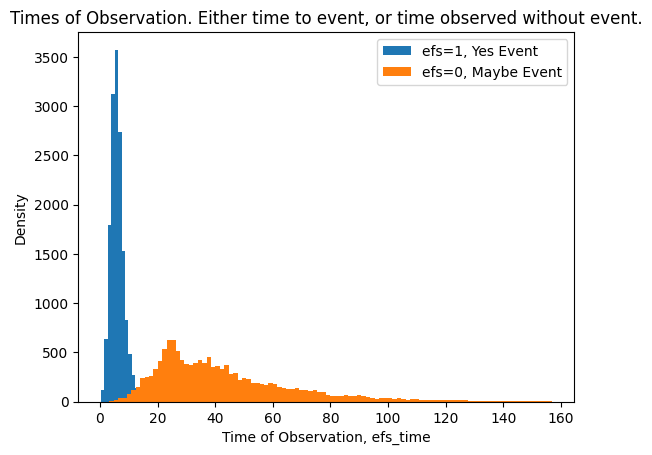

In [27]:
# ====================================================
# EDA
# ====================================================
plt.hist(train.filter(pl.col("efs") == 1)["efs_time"], bins=100, label="efs=1, Yes Event")
plt.hist(train.filter(pl.col("efs") == 0)["efs_time"], bins=100, label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()


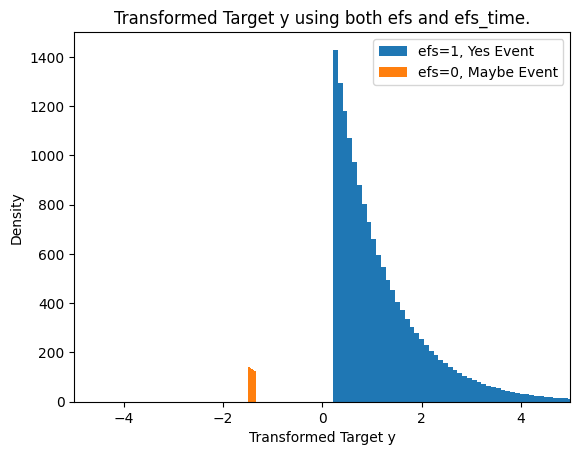

In [28]:
# ====================================================
# Transform two targets into one target
# ====================================================
mx = train.filter(pl.col("efs") == 1)["efs_time"].max()
mn = train.filter(pl.col("efs") == 0)["efs_time"].min()
train = (
    train.with_columns(
        pl.when(pl.col("efs") == 0).then(pl.col("efs_time") + mx - mn).otherwise(pl.col("efs_time")).alias("y")
    )
    .with_columns(pl.col("y").rank())
    .with_columns(pl.when(pl.col("efs") == 0).then(pl.col("y") + (2 * train.height)).otherwise(pl.col("y")))
    .with_columns(pl.col("y") / pl.col("y").max())
    .with_columns(pl.col("y").log())
    .with_columns(pl.col("y") - pl.col("y").mean())
    .with_columns(pl.col("y") * -1.0)
)

plt.hist(train.filter(pl.col("efs") == 1)["y"], bins=100, label="efs=1, Yes Event")
plt.hist(train.filter(pl.col("efs") == 0)["y"], bins=100, label="efs=0, Maybe Event")
plt.xlim((-5, 5))
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()
